In [1]:
from typing import List
import numpy as np
import torch.cuda
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import copy
import nashpy as nash

from utils.logger import Logger
from utils.io_utils import save_code
from utils.utils import model_comparison, generate_outputs_from_distribution
from utils.plot import two_action_prob_plot

from algorithm import RewardModel, MaximumLikelihoodEstimator,PolicyGradientOptimizer,DirectPreferenceOptimizer, SelfPlayPreferenceOptimizer, SPPOClosedForm
from policy import UniformPolicyModel,PolicyModel,Ref_PolicyModel
from utils.collect_data import collect_preference_data, NonMonotonicScalarToVectorNN, check_data_consistency, check_cyclic_order

In [2]:
from datetime import datetime

np.random.seed(5)

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir = f"./logs/test_{current_time}"
save_code(log_dir)

logger = Logger(log_dir)
writer = SummaryWriter(log_dir)

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

In [3]:
state_dim = 1
actions = [-10,0,10]

### Collect data

In [4]:
torch.manual_seed(5)
feature_func = NonMonotonicScalarToVectorNN()
pref_dataset, p_list = collect_preference_data(actions,60,feature_func)

In [5]:
p_list

array([[0.5       , 0.75489888, 0.44118223],
       [0.24510112, 0.5       , 0.83795365],
       [0.55881777, 0.16204635, 0.5       ]])

In [6]:
pref_dataset

[Transition(state=array([0]), action_0=0, action_1=-10, pref=1, chosen_probs=0.24510111981513732),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=1, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=0, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=0, action_1=10, pref=1, chosen_probs=0.8379536540835533),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=0, chosen_probs=0.44118222864585355),
 Transition(state=array([0]), action_0=-10, action_1=0, pref=0, chosen_probs=0.7548988801848626),
 Transition(state=array([0]), action_0=10, action_1=-10, pref=1, chosen_probs=0.5588177713541465),
 Transition(state=array([0]), action_0=-10, action_1=10, pref=1, chosen_probs=0.44118222864585355),
 Transition(state=

In [7]:
action_to_index = {-10: 0, 0: 1, 10: 2}

states = torch.cat([torch.tensor(x.state) for x in pref_dataset], dim=0)

positive_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_1] if x.pref == 1 else action_to_index[x.action_0]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

negative_actions = torch.cat(
    [torch.tensor(action_to_index[x.action_0] if x.pref == 1 else action_to_index[x.action_1]).unsqueeze(0) for x in pref_dataset],
    dim=0
)

print(f"states: {states}")
print(f"positive_actions: {positive_actions}")
print(f"negative_actions: {negative_actions}")

# check transition and consistency
print(f"check transition: {check_cyclic_order(p_list,actions)}")
print(f"check data consistency: {check_data_consistency(pref_dataset)}")

states: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
positive_actions: tensor([0, 1, 2, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 1, 2, 2, 2,
        2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 1, 2,
        0, 1, 0, 0, 1, 0, 2, 2, 1, 2, 1, 0])
negative_actions: tensor([1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 0, 0, 1,
        1, 1, 0, 1, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 2, 0, 1,
        1, 2, 2, 2, 0, 2, 1, 1, 2, 0, 0, 1])
check transition: (True, ('-10', '0', '10'))
check data consistency: 0.8


## Nash equilibrium

In [8]:
# compute nash equilibrium

# A = np.array([
#     [0.5, 0.1, 0.8],
#     [0.9, 0.5, 0.1],
#     [0.2, 0.9, 0.5]
# ])


game = nash.Game(p_list, -p_list)

equilibria = list(game.support_enumeration())

for eq in equilibria:
    print("Nash equilibrium of this game: ", eq[0])  

Nash equilibrium of this game:  [0.51859606 0.09025695 0.39114699]


In [9]:
# We use action 0 and action 1 to plot the scatter plot
nash_point= [eq[0][0],eq[0][1]]
nash_point

[0.5185960617933865, 0.09025694564670378]

## RLHF

In [10]:
learned_reward_model = RewardModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
)

In [11]:
mle_learner = MaximumLikelihoodEstimator(
    actions,
    learned_reward_model,
    learning_rate=1e-4,
    batch_size=64,
    logger=logger,
)

In [12]:
import time  # for seed

torch.manual_seed(time.time())
mle_learner.optimize(
    states, positive_actions, negative_actions, num_epochs=20
)

2024-11-20 21:01:18,328 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 0 loss: 0.6915 acc: 0.52
2024-11-20 21:01:18,334 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 2 loss: 0.6910 acc: 0.52
2024-11-20 21:01:18,339 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 4 loss: 0.6905 acc: 0.52
2024-11-20 21:01:18,344 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 6 loss: 0.6902 acc: 0.52
2024-11-20 21:01:18,349 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 8 loss: 0.6898 acc: 0.55
2024-11-20 21:01:18,353 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 10 loss: 0.6896 acc: 0.55
2024-11-20 21:01:18,358 - /home/hanwen/policy_optimization/exp/algorithm.py[line:124] - INFO: [Reward] Epoch 12 loss: 0.6894 acc: 0.55
2024-11-20 21:01:18,363 - /home/hanwen/policy_optimization/e

In [13]:
ref_policy = UniformPolicyModel(
    action_num=len(actions),
    device=device
).to(device)

ref_policy2 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.7,0.2,0.1]]),device).to(device)

ref_policy3 = Ref_PolicyModel(
    len(actions),torch.tensor([[1.0,0.0,0.0]]),device).to(device)

ref_policy4 = Ref_PolicyModel(
    len(actions),torch.tensor([[0.1,0.3,0.6]]),device).to(device)

print(ref_policy(torch.tensor([[0.0]])))
print(ref_policy2(torch.tensor([[0.0]])))
print(ref_policy3(torch.tensor([[0.0]])))
print(ref_policy4(torch.tensor([[0.0]])))

tensor([[0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[0.7000, 0.2000, 0.1000]], device='cuda:0')
tensor([[1., 0., 0.]], device='cuda:0')
tensor([[0.1000, 0.3000, 0.6000]], device='cuda:0')


In [14]:
states = torch.zeros(len(pref_dataset), 1, dtype=torch.float32).to(device) 
states.shape

torch.Size([60, 1])

In [15]:
# pg
policy = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [16]:
policy_optimizer = PolicyGradientOptimizer(
    policy=policy,
    reward_model=learned_reward_model,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 21:01:18,507 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 0 loss: -0.1941 reward: 0.1941 ref_reward: 0.1991 improvement: -2.52%
2024-11-20 21:01:18,514 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 2 loss: -0.1982 reward: 0.1982 ref_reward: 0.1991 improvement: -0.49%


2024-11-20 21:01:18,521 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 4 loss: -0.2019 reward: 0.2019 ref_reward: 0.1991 improvement: 1.40%
2024-11-20 21:01:18,527 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 6 loss: -0.2055 reward: 0.2055 ref_reward: 0.1991 improvement: 3.21%
2024-11-20 21:01:18,534 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 8 loss: -0.2090 reward: 0.2090 ref_reward: 0.1991 improvement: 4.97%
2024-11-20 21:01:18,540 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 10 loss: -0.2124 reward: 0.2124 ref_reward: 0.1991 improvement: 6.66%
2024-11-20 21:01:18,547 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch 12 loss: -0.2155 reward: 0.2155 ref_reward: 0.1991 improvement: 8.24%
2024-11-20 21:01:18,553 - /home/hanwen/policy_optimization/exp/algorithm.py[line:193] - INFO: [Policy] Epoch

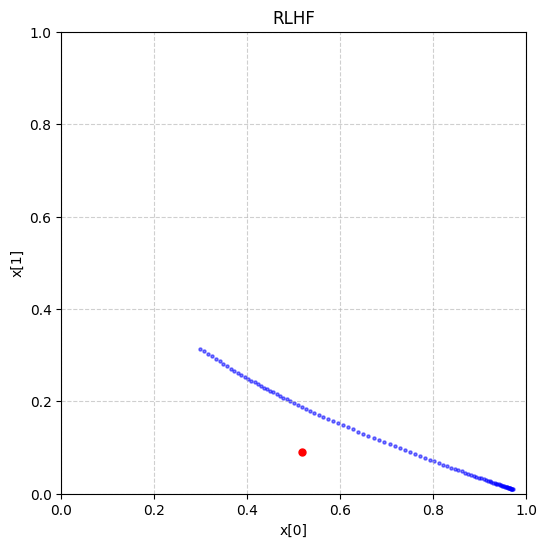

In [17]:
policy_optimizer.optimize(states=states, num_epochs=100)


In [18]:
state_0 = torch.tensor([0.0], dtype=torch.float32).to(device)
action_0 = torch.tensor([1,0,0], dtype=torch.float32).to(device)
action_1 = torch.tensor([0,0,1], dtype=torch.float32).to(device)
action_2 = torch.tensor([0,1,0], dtype=torch.float32).to(device)
print(learned_reward_model(state_0,action_0))
print(learned_reward_model(state_0,action_1))
print(learned_reward_model(state_0,action_2))

tensor([0.3088], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.1832], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0.0883], device='cuda:0', grad_fn=<ViewBackward0>)


In [19]:
# output the probabilities of each action from the learned policy
test_state = torch.tensor([[0.0]], dtype=torch.float32).to(device)  

with torch.no_grad():
    action_probs = policy(test_state)
    action_probs = action_probs.cpu().numpy()[0]  

actions = [-10, 0, 10]  
for action, prob in zip(actions, action_probs):
    print(f"P(action={action}) = {prob:.3f}")

# output the probabilities of each action from the reference policy
ref_probs = ref_policy(test_state).cpu().numpy()[0]
print("\nUniform policy probabilities:")
for action, prob in zip(actions, ref_probs):
    print(f"P(action={action}) = {prob:.3f}")

P(action=-10) = 0.971
P(action=0) = 0.010
P(action=10) = 0.019

Uniform policy probabilities:
P(action=-10) = 0.333
P(action=0) = 0.333
P(action=10) = 0.333


In [20]:
# compare the learned policy with the reference policy
score = model_comparison(policy, ref_policy,feature_func)
print(f"\nRLHF model and base model comparison score: {score:.3f}")


RLHF model and base model comparison score: 0.083


/home/hanwen/policy_optimization/exp/utils/utils.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)


## DPO

In [21]:
policy_dpo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_dpo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [22]:
dpo_optimizer_1 = DirectPreferenceOptimizer(
    policy=policy_dpo_1,
    ref_policy=ref_policy,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_2 = DirectPreferenceOptimizer(
    policy=policy_dpo_2,
    ref_policy=ref_policy2,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_3 = DirectPreferenceOptimizer(
    policy=policy_dpo_3,
    ref_policy=ref_policy3,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

dpo_optimizer_4 = DirectPreferenceOptimizer(
    policy=policy_dpo_4,
    ref_policy=ref_policy4,
    learning_rate=1e-3,
    batch_size=64,
    beta=1.0,
    logger=logger,
    nash_point = nash_point
)

2024-11-20 21:01:19,205 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.6939 grad norm: 0.0364 
2024-11-20 21:01:19,224 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.6905 grad norm: 0.0220 
2024-11-20 21:01:19,242 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.6890 grad norm: 0.0074 
2024-11-20 21:01:19,260 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.6889 grad norm: 0.0067 
2024-11-20 21:01:19,275 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.6891 grad norm: 0.0105 
2024-11-20 21:01:19,290 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.6889 grad norm: 0.0063 
2024-11-20 21:01:19,305 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.6888 grad n

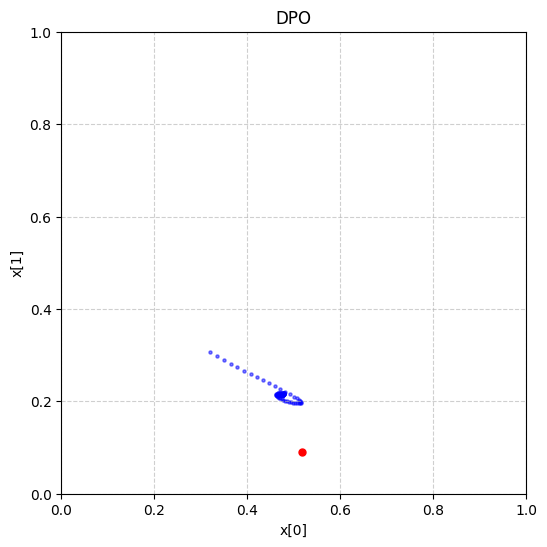

2024-11-20 21:01:19,671 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.7265 grad norm: 0.0954 
2024-11-20 21:01:19,688 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.7170 grad norm: 0.0858 
2024-11-20 21:01:19,704 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.7096 grad norm: 0.0812 
2024-11-20 21:01:19,719 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.7031 grad norm: 0.0756 
2024-11-20 21:01:19,735 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.6978 grad norm: 0.0652 
2024-11-20 21:01:19,750 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.6936 grad norm: 0.0497 
2024-11-20 21:01:19,766 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.6909 grad n

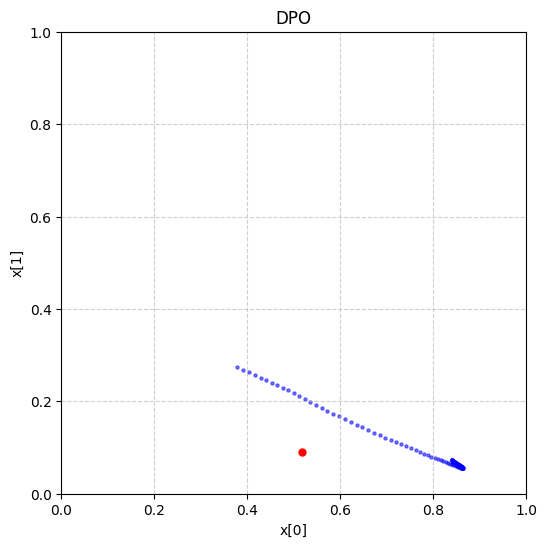

2024-11-20 21:01:20,139 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.8059 grad norm: 0.1444 
2024-11-20 21:01:20,156 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.7930 grad norm: 0.1454 
2024-11-20 21:01:20,172 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.7810 grad norm: 0.1470 
2024-11-20 21:01:20,188 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.7696 grad norm: 0.1525 
2024-11-20 21:01:20,203 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.7587 grad norm: 0.1571 
2024-11-20 21:01:20,219 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.7478 grad norm: 0.1602 
2024-11-20 21:01:20,235 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.7370 grad n

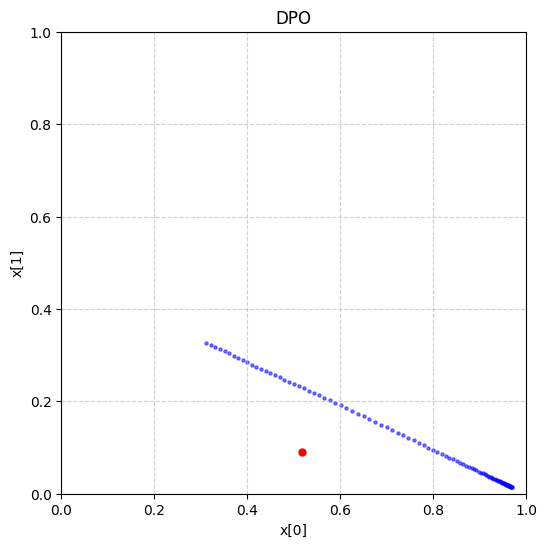

2024-11-20 21:01:20,612 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 0 loss: 0.7022 grad norm: 0.0530 
2024-11-20 21:01:20,629 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 5 loss: 0.6976 grad norm: 0.0453 
2024-11-20 21:01:20,644 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 10 loss: 0.6942 grad norm: 0.0383 
2024-11-20 21:01:20,660 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 15 loss: 0.6916 grad norm: 0.0307 
2024-11-20 21:01:20,677 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 20 loss: 0.6898 grad norm: 0.0191 
2024-11-20 21:01:20,693 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 25 loss: 0.6890 grad norm: 0.0070 
2024-11-20 21:01:20,709 - /home/hanwen/policy_optimization/exp/algorithm.py[line:313] - INFO: [Policy] Epoch: 30 loss: 0.6890 grad n

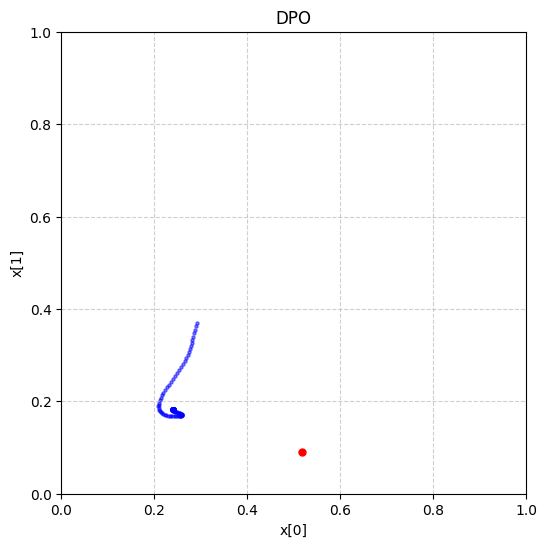

In [23]:
dpo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [0.33,0.33,0.33]

dpo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [0.7,0.2,0.1]

dpo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [1.0,0.0,0.0]

dpo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    num_epochs=100
) # ref_policy = [0.1,0.3,0.6]

In [24]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_dpo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
# compare the learned policy with the reference policy
score = model_comparison(policy_dpo_1, ref_policy,feature_func)
print(f"\nDPO model and base model comparison score: {score:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_dpo_2, ref_policy2,feature_func)
print(f"\nDPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_dpo_3, ref_policy3,feature_func)
print(f"\nDPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_dpo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_dpo_4, ref_policy4,feature_func)
print(f"\nDPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.474
P(action=0) = 0.215
P(action=10) = 0.311

DPO model and base model comparison score: 0.037

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.840
P(action=0) = 0.073
P(action=10) = 0.087

DPO model and base model comparison score: 0.000

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.969
P(action=0) = 0.014
P(action=10) = 0.017

DPO model and base model comparison score: 0.000

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.242
P(action=0) = 0.181
P(action=10) = 0.577

DPO model and base model comparison score: 0.010


## SPPO

In [25]:
policy_sppo_1 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_2 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_3 = PolicyModel(
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

policy_sppo_4 = PolicyModel(   
    state_dim,
    actions,
    hidden_dim=64,
    num_layers=2,
    device=device,
).to(device)

In [26]:
chosen_probs = torch.tensor([x.chosen_probs for x in pref_dataset], dtype=torch.float32).to(device)

In [27]:
sppo_optimizer_1 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_1,
    ref_policy=ref_policy,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_2 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_2,
    ref_policy=ref_policy2,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_3 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_3,
    ref_policy=ref_policy3,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

sppo_optimizer_4 = SelfPlayPreferenceOptimizer(
    policy=policy_sppo_4,
    ref_policy=ref_policy4,
    learning_rate=1e-2,
    batch_size=64,
    eta=1e-3,  
    logger=logger,
    nash_point = nash_point
)

2024-11-20 21:01:21,183 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.0041 grad norm: 0.0679 


2024-11-20 21:01:21,205 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0014 grad norm: 0.0377 
2024-11-20 21:01:21,226 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0004 grad norm: 0.0168 
2024-11-20 21:01:21,246 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0006 grad norm: 0.0219 
2024-11-20 21:01:21,267 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0001 grad norm: 0.0076 
2024-11-20 21:01:21,287 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0001 grad norm: 0.0094 
2024-11-20 21:01:21,308 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0001 grad norm: 0.0078 
2024-11-20 21:01:21,329 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 35 loss: 0.0000 grad 

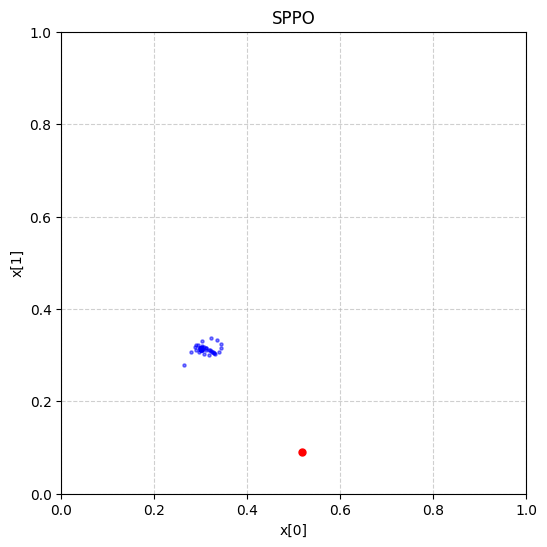

2024-11-20 21:01:22,572 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.1106 grad norm: 0.3645 
2024-11-20 21:01:22,593 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0034 grad norm: 0.0773 
2024-11-20 21:01:22,613 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0021 grad norm: 0.0477 
2024-11-20 21:01:22,634 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0006 grad norm: 0.0226 
2024-11-20 21:01:22,654 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0002 grad norm: 0.0158 
2024-11-20 21:01:22,675 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0002 grad norm: 0.0148 
2024-11-20 21:01:22,695 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0001 grad n

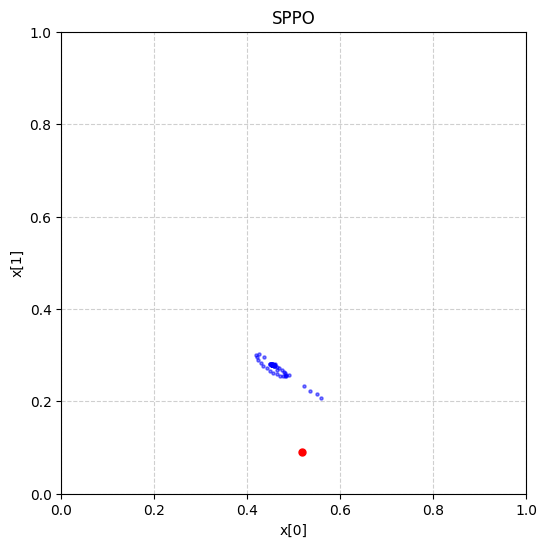

2024-11-20 21:01:23,950 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.4485 grad norm: 0.7275 
2024-11-20 21:01:23,971 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0072 grad norm: 0.1208 
2024-11-20 21:01:23,991 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0012 grad norm: 0.0423 
2024-11-20 21:01:24,012 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0014 grad norm: 0.0437 
2024-11-20 21:01:24,031 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0001 grad norm: 0.0103 
2024-11-20 21:01:24,051 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0006 grad norm: 0.0281 
2024-11-20 21:01:24,071 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0000 grad n

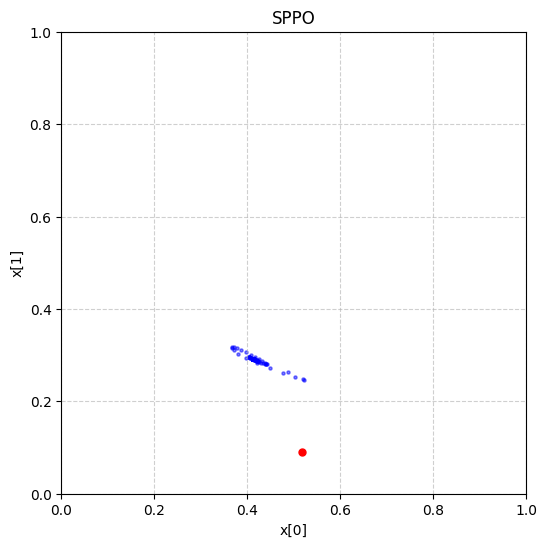

2024-11-20 21:01:25,479 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 0 loss: 0.1105 grad norm: 0.3483 
2024-11-20 21:01:25,501 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 5 loss: 0.0035 grad norm: 0.0649 
2024-11-20 21:01:25,522 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 10 loss: 0.0000 grad norm: 0.0051 
2024-11-20 21:01:25,542 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 15 loss: 0.0006 grad norm: 0.0192 
2024-11-20 21:01:25,563 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 20 loss: 0.0005 grad norm: 0.0160 
2024-11-20 21:01:25,583 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 25 loss: 0.0001 grad norm: 0.0058 
2024-11-20 21:01:25,604 - /home/hanwen/policy_optimization/exp/algorithm.py[line:431] - INFO: [Policy] Epoch: 30 loss: 0.0001 grad n

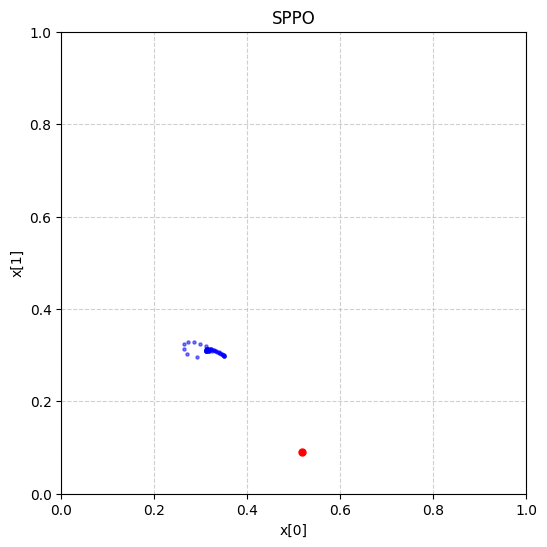

In [28]:
sppo_optimizer_1.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

sppo_optimizer_2.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

sppo_optimizer_3.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

sppo_optimizer_4.optimize(
    states=states,
    positive_actions=positive_actions,
    negative_actions=negative_actions,
    chosen_probs=chosen_probs,
    num_epochs=300
)

In [29]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    action_probs = policy_sppo_1(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
score = model_comparison(policy_sppo_1, ref_policy,feature_func)
print(f"\nSPPO model and base model comparison score: {score:.3f}")


with torch.no_grad():
    action_probs = policy_sppo_2(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score2 = model_comparison(policy_sppo_2, ref_policy2,feature_func)
print(f"\nSPPO model and base model comparison score: {score2:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_3(test_state)
    print("\nLearned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score3 = model_comparison(policy_sppo_3, ref_policy3,feature_func)
print(f"\nSPPO model and base model comparison score: {score3:.3f}")

with torch.no_grad():
    action_probs = policy_sppo_4(test_state)
    print("\nLearned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
score4 = model_comparison(policy_sppo_4, ref_policy4,feature_func)
print(f"\nSPPO model and base model comparison score: {score4:.3f}")


Learned policy probabilities with ref_model prob = [0.3333, 0.3333, 0.3333]:
P(action=-10) = 0.301
P(action=0) = 0.314
P(action=10) = 0.385

SPPO model and base model comparison score: -0.020

Learned policy probabilities with ref_model prob = [0.7, 0.2, 0.1]:
P(action=-10) = 0.455
P(action=0) = 0.279
P(action=10) = 0.267

SPPO model and base model comparison score: -0.040

Learned policy probabilities with ref_model prob = [1.0, 0.0, 0.0]:
P(action=-10) = 0.412
P(action=0) = 0.292
P(action=10) = 0.296

SPPO model and base model comparison score: -0.089

Learned policy probabilities with ref_model prob = [0.1, 0.3, 0.6]:
P(action=-10) = 0.313
P(action=0) = 0.312
P(action=10) = 0.375

SPPO model and base model comparison score: 0.057


## SPPO Closed-form solution

In [30]:
sppo_closed_form_1 = SPPOClosedForm(
    ref_policy=ref_policy,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_2 = SPPOClosedForm(   
    ref_policy=ref_policy2,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_3 = SPPOClosedForm(
    ref_policy=ref_policy3,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

sppo_closed_form_4 = SPPOClosedForm(
    ref_policy=ref_policy4,
    eta=1e-2,
    batch_size=64,
    logger=logger,
    device=device,
    nash_point=nash_point
)

2024-11-20 21:01:27,090 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([0.3333, 0.3333, 0.3333], device='cuda:0'), new_distribution = tensor([0.3338, 0.3332, 0.3330], device='cuda:0')
2024-11-20 21:01:27,095 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([0.3338, 0.3332, 0.3330], device='cuda:0'), new_distribution = tensor([0.3338, 0.3332, 0.3330], device='cuda:0')
2024-11-20 21:01:27,099 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([0.3338, 0.3332, 0.3330], device='cuda:0'), new_distribution = tensor([0.3343, 0.3345, 0.3312], device='cuda:0')
2024-11-20 21:01:27,103 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([0.3343, 0.3345, 0.3312], device='cuda:0'), new_distribution = tensor([0.3346, 0.3355, 0.3299], device='cuda:0')
2024-11-20 21:01

2024-11-20 21:01:27,130 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 10: ref_distribution = tensor([0.3405, 0.3386, 0.3209], device='cuda:0'), new_distribution = tensor([0.3410, 0.3391, 0.3199], device='cuda:0')
2024-11-20 21:01:27,134 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 11: ref_distribution = tensor([0.3410, 0.3391, 0.3199], device='cuda:0'), new_distribution = tensor([0.3413, 0.3393, 0.3194], device='cuda:0')
2024-11-20 21:01:27,138 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 12: ref_distribution = tensor([0.3413, 0.3393, 0.3194], device='cuda:0'), new_distribution = tensor([0.3418, 0.3383, 0.3198], device='cuda:0')
2024-11-20 21:01:27,142 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 13: ref_distribution = tensor([0.3418, 0.3383, 0.3198], device='cuda:0'), new_distribution = tensor([0.3433, 0.3383, 0.3183], device='cuda:0')
2024-11-20 2

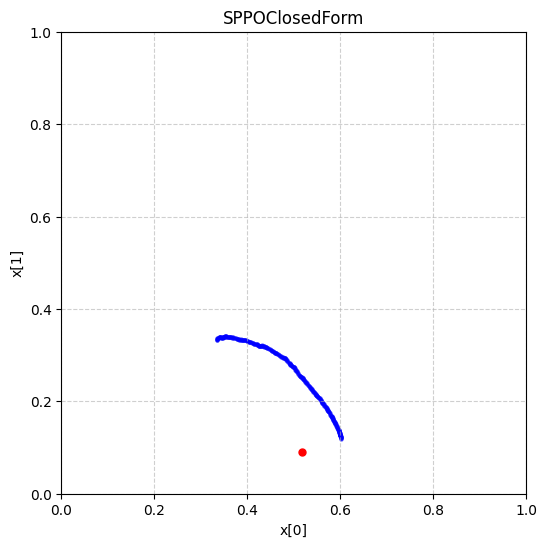

2024-11-20 21:01:28,467 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([0.7000, 0.2000, 0.1000], device='cuda:0'), new_distribution = tensor([0.7021, 0.1975, 0.1004], device='cuda:0')
2024-11-20 21:01:28,472 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([0.7021, 0.1975, 0.1004], device='cuda:0'), new_distribution = tensor([0.7035, 0.1960, 0.1005], device='cuda:0')
2024-11-20 21:01:28,476 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([0.7035, 0.1960, 0.1005], device='cuda:0'), new_distribution = tensor([0.7053, 0.1940, 0.1008], device='cuda:0')
2024-11-20 21:01:28,480 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([0.7053, 0.1940, 0.1008], device='cuda:0'), new_distribution = tensor([0.7069, 0.1921, 0.1009], device='cuda:0')
2024-11-20 21:01

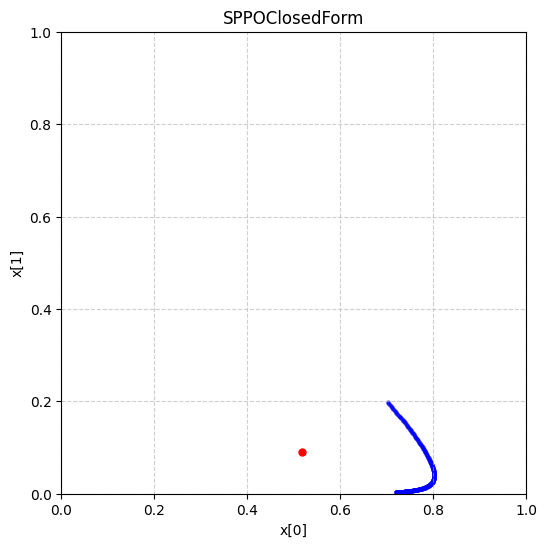

2024-11-20 21:01:29,873 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:01:29,878 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:01:29,881 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:01:29,885 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([1., 0., 0.], device='cuda:0'), new_distribution = tensor([1., 0., 0.], device='cuda:0')
2024-11-20 21:01:29,889 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 4: ref_d

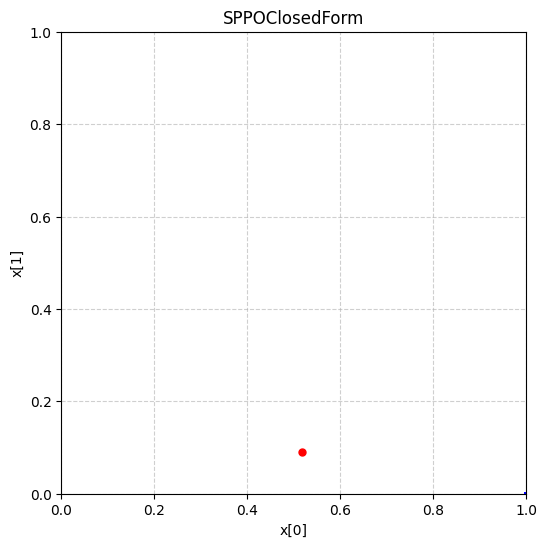

2024-11-20 21:01:31,206 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 0: ref_distribution = tensor([0.1000, 0.3000, 0.6000], device='cuda:0'), new_distribution = tensor([0.1000, 0.3033, 0.5968], device='cuda:0')
2024-11-20 21:01:31,210 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 1: ref_distribution = tensor([0.1000, 0.3033, 0.5968], device='cuda:0'), new_distribution = tensor([0.1002, 0.3050, 0.5947], device='cuda:0')
2024-11-20 21:01:31,214 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 2: ref_distribution = tensor([0.1002, 0.3050, 0.5947], device='cuda:0'), new_distribution = tensor([0.1003, 0.3078, 0.5919], device='cuda:0')
2024-11-20 21:01:31,218 - /home/hanwen/policy_optimization/exp/algorithm.py[line:507] - INFO: Iteration 3: ref_distribution = tensor([0.1003, 0.3078, 0.5919], device='cuda:0'), new_distribution = tensor([0.1003, 0.3106, 0.5891], device='cuda:0')
2024-11-20 21:01

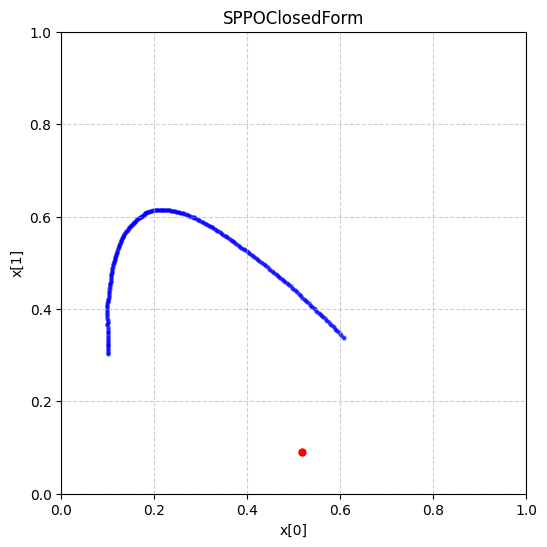

In [31]:
sppo_distribution_1 = sppo_closed_form_1.optimize(
    p_list=p_list,
    num_iters=300
)   

sppo_distribution2 = sppo_closed_form_2.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution3 = sppo_closed_form_3.optimize(
    p_list=p_list,
    num_iters=300
)

sppo_distribution4 = sppo_closed_form_4.optimize(
    p_list=p_list,
    num_iters=300
)

In [40]:
test_state = torch.zeros(1, 1, dtype=torch.float32).to(device)
with torch.no_grad():
    
    print("\n ##### Learned policy probabilities of RLHF: #####")
    action_probs = policy(test_state)
    print("\nLearned policy probabilities(RLHF):")
    for action, prob in zip(actions, action_probs[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    


 ##### Learned policy probabilities of RLHF: #####

Learned policy probabilities(RLHF):
P(action=-10) = 0.971
P(action=0) = 0.010
P(action=10) = 0.019


In [42]:
print("\n ##### Learned policy probabilities of DPO: #####")
with torch.no_grad():
    action_probs_dpo1 = policy_dpo_1(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_dpo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")

    action_probs_dpo2 = policy_dpo_2(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_dpo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs_dpo3 = policy_dpo_3(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_dpo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs_dpo4 = policy_dpo_4(test_state)
    print("\nLearned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_dpo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")


 ##### Learned policy probabilities of DPO: #####

Learned policy probabilities(DPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.474
P(action=0) = 0.215
P(action=10) = 0.311

Learned policy probabilities(DPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.840
P(action=0) = 0.073
P(action=10) = 0.087

Learned policy probabilities(DPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.969
P(action=0) = 0.014
P(action=10) = 0.017

Learned policy probabilities(DPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.242
P(action=0) = 0.181
P(action=10) = 0.577


In [43]:
print("\n ##### Learned policy probabilities of SPPO: #####")
with torch.no_grad():
    action_probs_sppo1 = policy_sppo_1(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs_sppo2 = policy_sppo_2(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs_sppo3 = policy_sppo_3(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        
    action_probs_sppo4 = policy_sppo_4(test_state)
    print("\nLearned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4[0].cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")


 ##### Learned policy probabilities of SPPO: #####

Learned policy probabilities(SPPO), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.301
P(action=0) = 0.314
P(action=10) = 0.385

Learned policy probabilities(SPPO), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.455
P(action=0) = 0.279
P(action=10) = 0.267

Learned policy probabilities(SPPO), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 0.412
P(action=0) = 0.292
P(action=10) = 0.296

Learned policy probabilities(SPPO), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.313
P(action=0) = 0.312
P(action=10) = 0.375


In [41]:
print("\n ##### Learned policy probabilities of SPPO-ClosedForm: #####")
with torch.no_grad():
    action_probs_sppo1 = sppo_distribution_1
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:")
    for action, prob in zip(actions, action_probs_sppo1.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs_sppo2 = sppo_distribution2
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:")
    for action, prob in zip(actions, action_probs_sppo2.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs_sppo3 = sppo_distribution3
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:")
    for action, prob in zip(actions, action_probs_sppo3.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
    
    action_probs_sppo4 = sppo_distribution4
    print("\nLearned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:")
    for action, prob in zip(actions, action_probs_sppo4.cpu().numpy()):
        print(f"P(action={action}) = {prob:.3f}")
        


 ##### Learned policy probabilities of SPPO-ClosedForm: #####

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.33,0.33,0.33]:
P(action=-10) = 0.602
P(action=0) = 0.119
P(action=10) = 0.279

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.7,0.2,0.1]:
P(action=-10) = 0.719
P(action=0) = 0.003
P(action=10) = 0.278

Learned policy probabilities(SPPO-ClosedForm), ref_model = [1.0,0.0,0.0]:
P(action=-10) = 1.000
P(action=0) = 0.000
P(action=10) = 0.000

Learned policy probabilities(SPPO-ClosedForm), ref_model = [0.1,0.3,0.6]:
P(action=-10) = 0.608
P(action=0) = 0.338
P(action=10) = 0.055
